In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [33]:
with open('steady_data_2.json') as f:
    data = pd.read_json(f)

data['data'].head()


0    30.1,1022.46,57.01426816622416,9.9858298333485...
1    30.13,1022.65,57.01426799986098,9.985833000077...
2    30.13,1022.66,57.01426783349779,9.985833333333...
3    30.13,1022.65,57.01426733334859,9.985832833449...
4    30.13,1022.62,57.01426666683621,9.985833333333...
Name: data, dtype: object

In [34]:
df = pd.DataFrame(
    columns=["temp", "pressure", "latitude", "longitude", "altitude", "speed", "course"]
)
for i, line in enumerate(data["data"]):
    a = line.split(",")
    df.loc[i] = [
        float(a[0]),
        float(a[1]),
        float(a[2]),
        float(a[3]),
        (a[4][5:-1] if a[4] != "None" else None),
        (a[5][5:-1] if a[5] != "None" else None),
        (a[6][5:-1] if a[6] != "None" else 0),
    ]


In [35]:
#print all the variation of the different columns
b = df['altitude'].dropna().astype(float)
print(len(b),len(df['altitude']))
c = df['speed'].dropna().astype(float)
d = df['course'].dropna().astype(float)
print(df['temp'].var(),df['pressure'].var(),df['latitude'].var(),df['longitude'].var(),b.var(),c.var(),d.var())


761 761
0.01135029773843281 0.0036458537934845776 4.950012648154604e-09 6.169198512229982e-09 322.8310754893146 0.0042174041090347406 0.0


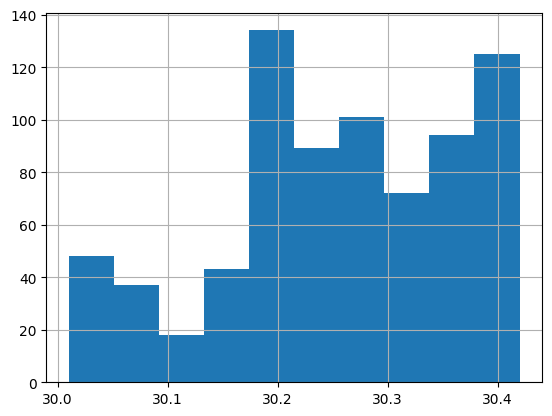

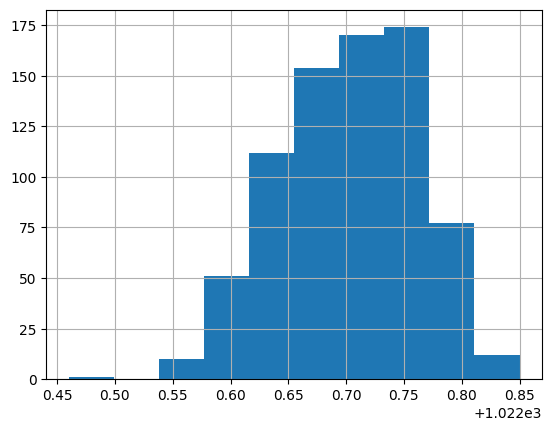

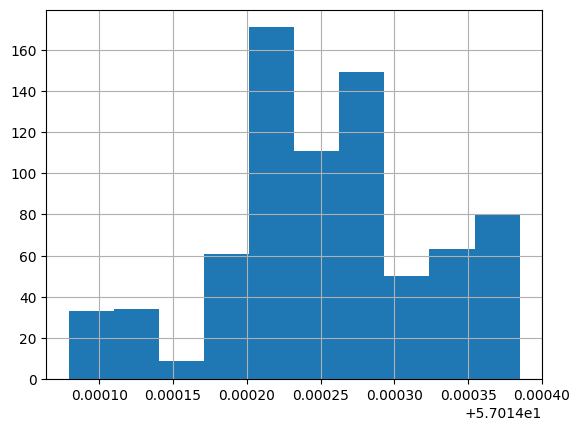

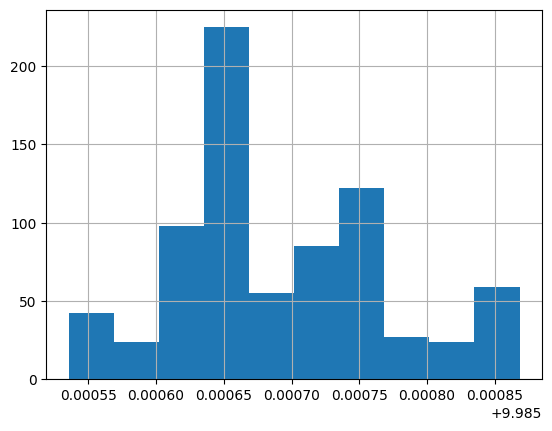

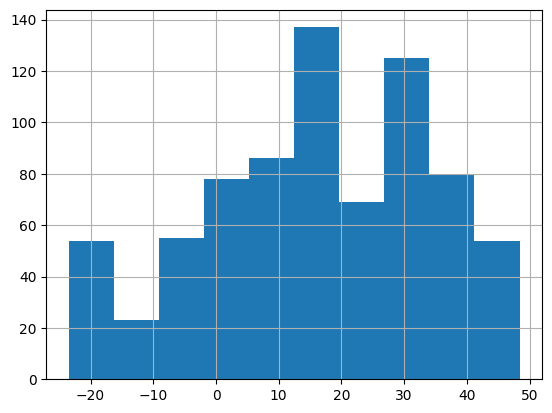

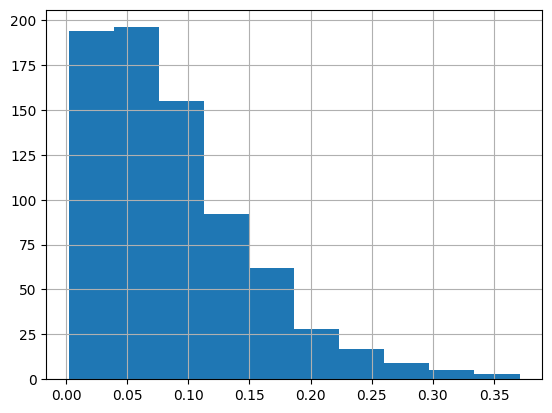

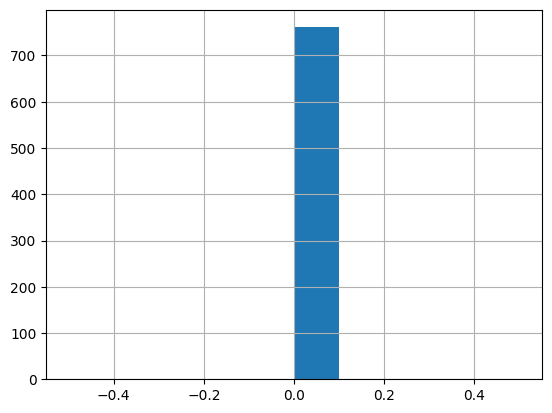

In [36]:
# Show histogram of the different columns
df['temp'].hist()
plt.show()
df['pressure'].hist()
plt.show()
df['latitude'].hist()
plt.show()
df['longitude'].hist()
plt.show()
b.hist()
plt.show()
c.hist()
plt.show()
d.hist()
plt.show()

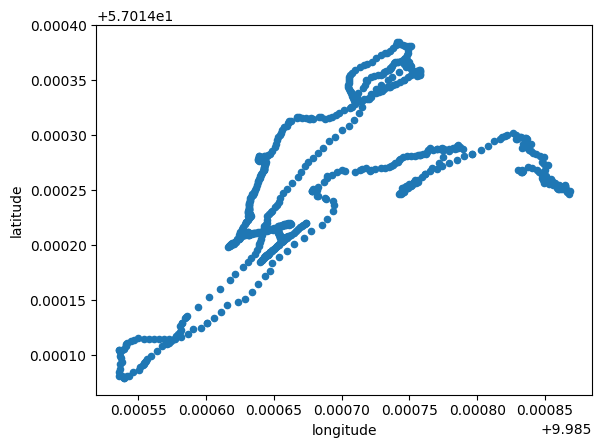

In [37]:
# Scatterplot of the lattiude vs longitude
df.plot.scatter(y='latitude',x='longitude')
plt.show()

In [38]:
# Making the framework for a kalman filter
import pykalman as pk
del_t = 1
R_0 = 8.3144598
T_0 = 288.15
P_0 = 101325
G_0 = 9.80665
M = 0.0289644

v_alt = np.roll(df["altitude"].astype(float), 1) - df["altitude"].astype(float)
press_alt = -((np.log((df["pressure"]*100) / P_0) * T_0 * R_0) / (M * G_0))
press_alt = press_alt - press_alt.mean()
v_alt_press = np.roll(press_alt, 1) - (press_alt)
R = np.eye(8) * np.array(
    [
        df["latitude"].var(),
        df["longitude"].var(),
        b.var(),
        v_alt.var(),
        press_alt.var(),
        v_alt_press.var(),
        c.var(),
        v_alt.var(),
    ]
)
R[:2,:2] = np.cov(df["latitude"],df["longitude"])




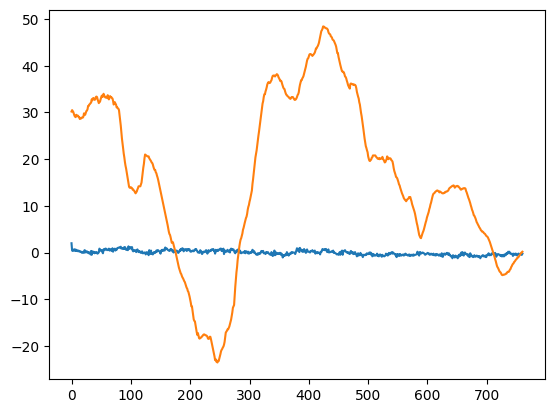

In [39]:
#plot the altitude from the pressure
plt.plot(press_alt)
plt.plot(df["altitude"].astype(float))

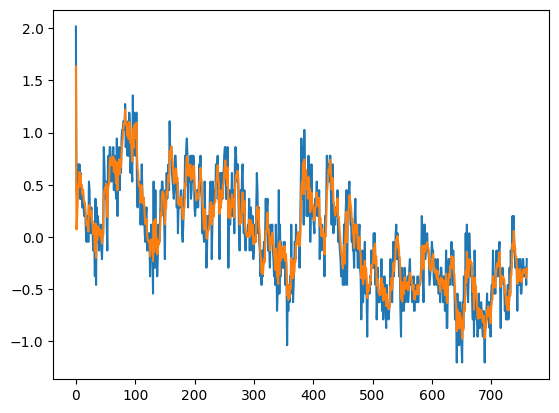

In [40]:



H = np.array(
    [
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
    ]
)


phi = np.array(
    [
        [1, 0, 0, del_t, 0, 0],
        [0, 1, 0, 0, del_t, 0],
        [0, 0, 1, 0, 0, del_t],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
    ]
)


initial_state_mean = np.zeros(6)
np.sin(df["course"].astype(float)).shape
np.cos(df["course"].astype(float)).shape

obs = np.vstack(
    (
        df["latitude"].values,
        df["longitude"].values,
        df["altitude"].astype(float).values,
        v_alt,
        press_alt,
        v_alt_press,
        np.sin(np.deg2rad(df["course"].astype(float))) * df["speed"].astype(float),
        np.cos(np.deg2rad(df["course"].astype(float))) * df["speed"].astype(float),
    )
)


kf = pk.KalmanFilter(
    transition_matrices=phi,
    observation_matrices=H,
    observation_covariance=R,
    initial_state_mean=initial_state_mean,
    transition_covariance=np.eye(6)*0.1,
)
obs.transpose().shape
filtered_state_means,filtered_state_covariances = kf.filter(obs.transpose())
# observations = df[["latitude", "longitude", "pressure", "course", "speed"]].values
# alt_obs = df["altitude"].astype(float).values
# # print(np.roll(df['altitude'].values,1)-df['altitude'].values)
# v_alt_obs = np.roll(df["altitude"].astype(float), 1) - df["altitude"].astype(float)
# print(observations.shape, alt_obs.shape)
# np.append(observations, alt_obs).shape
plt.plot(press_alt)
plt.plot(filtered_state_means[:,2])
# filtered_state_means.shape
# # filtered_state_est = kf.filter(df[['latitude','longitude','altitude','speed','course']].values)
# # kf.filter(df[['latitude','longitude','altitude','speed','pressure','course']].values)

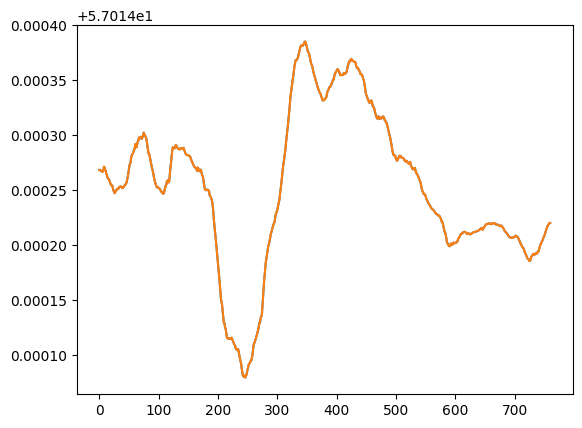

In [41]:
plt.plot(df['latitude'])
plt.plot(filtered_state_means[:,0])

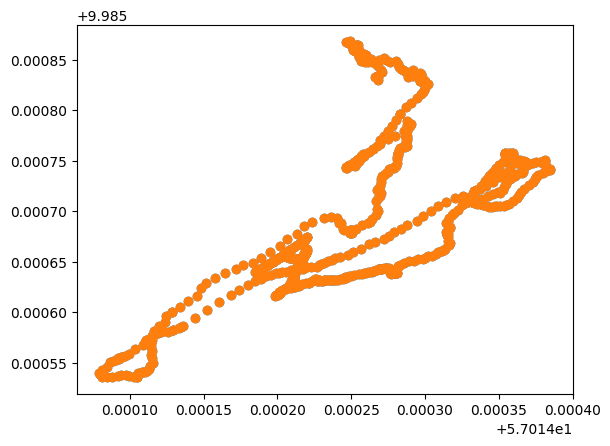

In [42]:
#Scatter plot the position and the filtered position
plt.scatter(df["latitude"], df["longitude"])
plt.scatter(filtered_state_means[:,0],filtered_state_means[:,1])
